In [ ]:
import marimo as mo

In [ ]:
from FMNM.BS_pricer import BS_pricer
from FMNM.Parameters import Option_param
from FMNM.Processes import Diffusion_process

import numpy as np
import scipy.stats as ss
from scipy.integrate import quad
from functools import partial

import matplotlib.pyplot as plt

# '%matplotlib inline' command supported automatically in marimo

<a id='sec1'></a>
## European option

Under the Black-Scholes (BS) model, the best method to price a vanilla European option is to use the [BS closed formula](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model).

The **BS formula** for a call is:

$$ C(t,T,S,K,r,\sigma) = S \, N(d_1) - K e^{-r(T-t)} N(d_2) $$

with

$$ d_1 = \frac{1}{\sigma \sqrt{T-t}} \biggl[ \log \biggl( \frac{S}{K} \biggr) + \biggl(r + \frac{\sigma^2}{2} \biggr) (T-t) \biggr] \quad \text{and} \quad d_2 = d_1 - \sigma \sqrt{T-t} $$

where $N$ is the cumulative distribution function of a standard normal random variable.
The formula for a put is similar and can be found in the wiki page.

The value of an option can be also computed as the discounted expectation of a future payoff in this way:

$$\begin{aligned}
 C(s,K,t, T) &= e^{-r(T-t)} \mathbb{E}^{\mathbb{Q}}\biggl[ (S_T - K)^+ \bigg| S_t=s \biggr] \\
            &= e^{-r(T-t)} \int_0^{\infty}\, (s' - K)^+ \, f(s'|s) \, ds' \\
            &= e^{-r(T-t)} \int_K^{\infty}\, (s' - K) \, f(s'|s) \, ds'
\end{aligned}$$

where $f(s'|s)$ is the risk neutral transition probability of the process $\{S_u\}_{u\in [t,T]}$ starting at $S_t=s$. This is a log-normal density function

$$ f(s'|s) = \frac{1}{s' \sigma \sqrt{2\pi (T-t)}} \; e^{- \frac{ \biggl[\log(s') - \bigl(\log(s) + (r-\frac{1}{2} \sigma^2)(T-t) \bigr) \biggr]^2}{2\sigma^2 (T-t)}} $$


#### Comment:
Usually in statistics random variables are indicated by capital letters, and non-random variables are indicated with small letters. However, it is very common to indicate the stock price in the Black-Scholes formula with a capital letter e.g [wiki notation](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model#Notation). I'm going to use a capital letters to indicate random variables, and small letters for non random. However there will be exceptions where it will be clear from the context e.g. strike K and maturity T are non random, or $S_0$ most of the time is a fixed variable.

### Let us analyze better the previous formulas



\begin{align*}
 C(s,t,K,T) &= e^{-r(T-t)} \mathbb{E}^{\mathbb{Q}}\biggl[ (S_T - K)^+ \bigg| S_t=s \biggr] \\
            &= e^{-r(T-t)} \mathbb{E}^{\mathbb{Q}}\biggl[ S_T \mathbb{1}_{S_T >K} \bigg| S_t=s \biggr]
              - e^{-r(T-t)} \mathbb{E}^{\mathbb{Q}}\biggl[ K \mathbb{1}_{S_T >K} \bigg| S_t=s \biggr] \\
            &= e^{-r(T-t)} \mathbb{E}^{\mathbb{Q}}\biggl[ S_T \mathbb{1}_{S_T >K} \bigg| S_t=s \biggr]
              - e^{-r(T-t)} K \, \underbrace{\mathbb{Q}\biggl[ S_T >K \bigg| S_t=s \biggr]}_{N(d_2)} \\
\end{align*}

Let us introduce the following change of measure (under the stock numeraire):

$$ \begin{aligned}
\frac{d \tilde{\mathbb{Q}} }{ d \mathbb{Q} } &= \frac{S_T}{\mathbb{E}^\mathbb{Q}[S_T | S_t]} = \frac{S_T}{S_t e^{r(T-t)}}  \\
                                            &= \frac{S_t e^{(r -\frac{1}{2}\sigma^2)(T-t) + \sigma W_{T-t}} }{S_t e^{r(T-t)}} \\
                                            &=   e^{ -\frac{1}{2}\sigma^2(T-t) + \sigma W_{T-t} } \quad \text{(exponential martingale)}
\end{aligned} $$

By [Girsanov theorem](https://en.wikipedia.org/wiki/Girsanov_theorem), under $\tilde{\mathbb{Q}}$ the driving Brownian motion has the new dynamics

$$ \tilde{W_t} = W_t - \sigma t $$

and the corresponding stock dynamics becomes

$$\begin{aligned}
 \frac{dS_t}{S_t} &= r dt + \sigma dW_t \\
                  &= (r+\sigma^2) dt + \sigma d\tilde{W}_t
\end{aligned}$$

The first term is

$$ \begin{aligned}
 e^{-r(T-t)} \mathbb{E}^{\mathbb{Q}}\biggl[ S_T \mathbb{1}_{S_T >K} \bigg| S_t=s \biggr] =& e^{-r(T-t)} \mathbb{E}^{\tilde{\mathbb{Q}}}
                 \biggl[ \frac{d \mathbb{Q} }{ d \tilde{\mathbb{Q}}}  S_T \mathbb{1}_{S_T >K} \bigg| S_t=s \biggr] \\
                     =& e^{-r(T-t)} \mathbb{E}^{\tilde{\mathbb{Q}}}
                 \biggl[ \frac{e^{r(T-t)}S_t}{S_T}  S_T \mathbb{1}_{S_T > K} \bigg| S_t=s \biggr] \\
                    =& \; s \, \underbrace{\tilde{\mathbb{Q}} ( S_T > K | S_t=s)}_{N(d_1)}
\end{aligned}$$

We have just seen how to interpret the terms $N(d_1)$ and $N(d_2)$. These are the risk neutral probabilities of $S_T > K$ in the stock and money market numeraires respectively.

I implemented the BS closed formula in the class `BS_pricer`.
Let us consider the following set of parameters, that will be recurrent in all the next notebooks.

In [ ]:
S0 = 100.0  # spot stock price
K = 100.0  # strike
T = 1.0  # maturity
r = 0.1  # risk free rate
sig = 0.2  # diffusion coefficient or volatility

In [ ]:
call = BS_pricer.BlackScholes("call", S0, K, T, r, sig)
put = BS_pricer.BlackScholes("put", S0, K, T, r, sig)
print("Call price: ", call)
print("Put price: ", put)

Call price:  13.269676584660893
Put price:  3.753418388256833


<a id='sec1.1'></a>
### Put-Call parity

This is an important formula [wiki page](https://en.wikipedia.org/wiki/Put%E2%80%93call_parity)

$$ \text{Call} - \text{Put} = S_0 - K e^{-rT}  $$

Let us check if it works:

In [ ]:
print(call)
print(put + S0 - K * np.exp(-r * T))

13.269676584660893
13.269676584660886


<a id='sec2'></a>
## Numerical integration

I want to play a bit with the different formulas written above.

Let us compute the option prices by integrating the log-normal density:

In [ ]:
e_ret = np.log(S0) + (r - 0.5 * sig**2) * T  # expected return of the log-price
vol = sig * np.sqrt(T)  # standard deviation of the log-price


# log-normal density (defined above)
def log_normal(x, e_ret, vol):
    return 1 / (x * vol * np.sqrt(2 * np.pi)) * np.exp(-((np.log(x) - e_ret) ** 2) / (2 * vol**2))

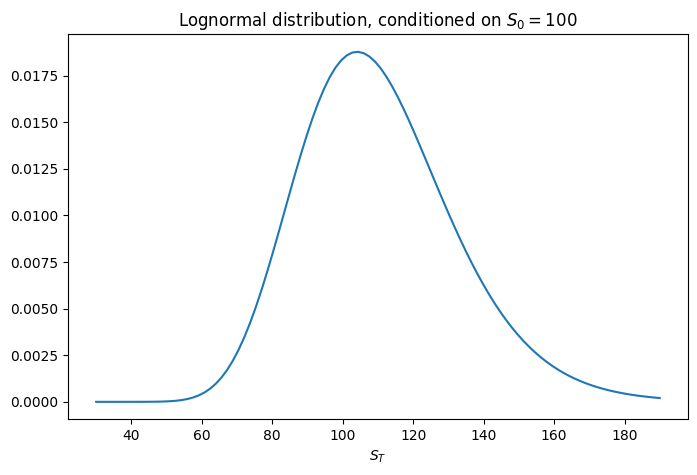

In [ ]:
plt.figure(figsize=(8, 5))
x = np.linspace(30, 190, 100)
plt.plot(x, log_normal(x, e_ret, vol))
plt.title("Lognormal distribution, conditioned on $S_0=100$")
plt.xlabel("$S_T$")
plt.show()

The function `log_normal(x, e_ret, vol)` defined above, corresponds to the scipy.stats function:
```
ss.lognorm.pdf(x, vol, scale=np.exp(e_ret) ).
```

In the next calculation, I'm going to use the scipy function.
Let us perform the integration with the `scipy.integrate` function [quad](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html):

In [ ]:
def integrand_LN(S, strike, e_ret, vol, payoff):
    if payoff == 'call':
        return (S - strike) * ss.lognorm.pdf(S, vol, scale=np.exp(e_ret))
    elif payoff == 'put':
        return (strike - S) * ss.lognorm.pdf(S, vol, scale=np.exp(e_ret))
call_1 = quad(integrand_LN, K, np.inf, args=(K, e_ret, vol, 'call'))[0] * np.exp(-r * T)
put_1 = quad(integrand_LN, 0, K, args=(K, e_ret, vol, 'put'))[0] * np.exp(-r * T)
print('Call price: {} \nPut price: {} '.format(call_1, put_1))

Call price: 13.269676584660926 
Put price: 3.753418388256827 


The put option payoff $(K-S_T)^+$ is positive for $S_T < K$.
- In the call case, the integration is from $K$ to $\infty$.
- In the put case, the integration is from $0$ to $K$.

What if we use the change of measure proposed above?  In this way the integrations are simpler.
Let us compute $\tilde{\mathbb{Q}}( S_T > K )$ and $\mathbb{Q}( S_T > K )$.

In [ ]:
# expected return of the log-price under the new measure
e_ret_1 = np.log(S0) + (r + 0.5 * sig**2) * T

Q1 = quad(lambda S: ss.lognorm.pdf(S, vol, scale=np.exp(e_ret_1)), K, np.inf)[0]
print("Risk neutral probability under stock numeraire,\n Q1 =", Q1)
Q2 = quad(lambda S: ss.lognorm.pdf(S, vol, scale=np.exp(e_ret)), K, np.inf)[0]
print("Risk neutral probability under money market numeraire,\n Q2 =", Q2)

print("BS call price: ", S0 * Q1 - K * np.exp(-r * T) * Q2)

Risk neutral probability under stock numeraire,
 Q1 = 0.7257468822499276
Risk neutral probability under money market numeraire,
 Q2 = 0.6554217416103069
BS call price:  13.26967658466257


It is quite common to compute the Black-Scholes formula using $N(d_1)$ and $N(d_2)$.
The reason is that the cumulative function of the standard Normal distribution is more accessible (I guess). In the `BS_pricer` class I used the function `scipy.stats.norm.cdf`.

For completeness, let me recall that if $X_T$ is a Normal random variable, then $S_T = S_0 e^{X_T}$ is Log-Normal. Therefore we have:

$$ \mathbb{Q}( S_T > K ) = \mathbb{Q}\biggl( S_0 e^{X_T} > K \biggr) = \mathbb{Q}\biggl( X_T > \log \frac{K}{S_0} \biggr). $$

This permits to use the Normal cumulative function.

<a id='sec3'></a>
## Monte Carlo method

I'm going to simulate the random variables:

$$ S_T^i = S_0 e^{(r -\frac{1}{2}\sigma^2)T + \sigma W_{T}^i} $$

for $1 \leq i \leq N$.
Then use the approximation for a call option:

$$ \mathbb{E}^{\mathbb{Q}}\biggl[ (S_T - K)^+ \bigg| S_0 \biggr] \;
\approx \; \frac{1}{N} \sum_{i=1}^N (S_T^i - K)^+
$$

For a put option I use this payoff $(K - S_T )^+$ inside the expectation.

In [ ]:
np.random.seed(seed=44)
N = 10000000
W = ss.norm.rvs((r - 0.5 * sig ** 2) * T, np.sqrt(T) * sig, N)
_S_T = S0 * np.exp(W)
call_2 = np.mean(np.exp(-r * T) * np.maximum(_S_T - K, 0))
put_2 = np.mean(np.exp(-r * T) * np.maximum(K - _S_T, 0))
call_err = ss.sem(np.exp(-r * T) * np.maximum(_S_T - K, 0))
put_err = ss.sem(np.exp(-r * T) * np.maximum(K - _S_T, 0))

In [ ]:
print('Call price: {}, with error: {}'.format(call_2, call_err))
print('Put price: {}, with error: {}'.format(put_2, put_err))

Call price: 13.263338006636662, with error: 0.005093638687208466
Put price: 3.7553894006350093, with error: 0.002214066662789331


### BS_pricer

In the next notebooks I will present better the class `BS_pricer`. But now let's have a look at the prices obtained by different pricing methods:

In [ ]:
# Creates the object with the parameters of the option
opt_param = Option_param(S0=100, K=100, T=1, exercise="European", payoff="call")
# Creates the object with the parameters of the process
diff_param = Diffusion_process(r=0.1, sig=0.2)
# Creates the pricer object
BS = BS_pricer(opt_param, diff_param)

In [ ]:
BS.closed_formula()

np.float64(13.269676584660893)

In [ ]:
BS.Fourier_inversion()

np.float64(13.269676584660623)

In [ ]:
BS.MC(N=30000000, Err=True, Time=True)
# output is: price, standard error and execution time

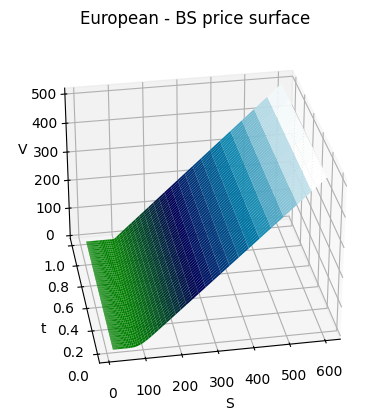

In [ ]:
BS.mesh_plt()  # PDE method

The PDE approach is the topic of the notebook **2.1**.

<a id='sec4'></a>
## Binomial tree


Of course I cannot forget about the Binomial model!
This is a simple but very powerful numerical method!

I expect you to be familiar with this model. If not, have a look at the [wiki page](https://en.wikipedia.org/wiki/Binomial_options_pricing_model).
Although I said I expect you to know the model, I'm not expecting that you have already implemented it!
Therefore, here I present an efficient implementation:

In [ ]:
N_1 = 15000
payoff = 'call'
dT = float(T) / N_1
u = np.exp(sig * np.sqrt(dT))
d = 1.0 / u
V = np.zeros(N_1 + 1)
_S_T = np.array([S0 * u ** k * d ** (N_1 - k) for k in range(N_1 + 1)])
a = np.exp(r * dT)
p = (a - d) / (u - d)
q = 1.0 - p
if payoff == 'call':
    V[:] = np.maximum(_S_T - K, 0.0)
else:
    V[:] = np.maximum(K - _S_T, 0.0)
for i in range(N_1 - 1, -1, -1):
    V[:-1] = np.exp(-r * dT) * (p * V[1:] + q * V[:-1])
print('BS Tree Price: ', V[0])

BS Tree Price:  13.269537371978052


The stock price on each node of a binomial tree is

$$S_n^{(k)} = u^{k} d^{n-k} S_0 \quad \text{for} \quad k \in \{ 0, ..., n \} \quad \text{and} \quad n \in \{ 0, ..., N \}$$

where the price at $S_n^{(k)}$ is obtained starting from $S_0^{(0)}$ := $S_0$ and applying $k$ up factors and $(n-k)$ down factors.

In a (recombining) binomial tree at each time point $n$ there are $i+1$ nodes.
The total number of nodes of a binomial tree is

\begin{align}
 \sum_{i=0}^N (1+i) &= \sum_{i=0}^N 1 + \sum_{i=0}^N i \\
 &= (N+1) + N(N+1)/2  \\
 &= (N+1)(N+2)/2.
\end{align}

Since $u = 1/d$, we can rewrite the formula above as
$S_n^{(k)} = u^{2k - n}\, S_0 \quad \text{for} \quad k \in \{ 0, ..., n \} \quad \text{and} \quad n \in \{ 0, ..., N \}$

In this way, we can decrease the number of operations and increase the speed of the program:

In [ ]:
_S_T = np.array([S0 * u ** j * d ** (N_1 - j) for j in range(N_1 + 1)])

In [ ]:
_S_0N = S0 / u ** N_1
_S_T = np.array([_S_0N * u ** (2 * j) for j in range(N_1 + 1)])

In [ ]:
_S_0N = S0 / u ** N_1
_S_T = np.array([_S_0N * u ** j for j in range(0, 2 * N_1 + 1, 2)])

The last approach for the computation of $S_T$ is the fastest.

<a id='sec5'></a>
## Limits of the model

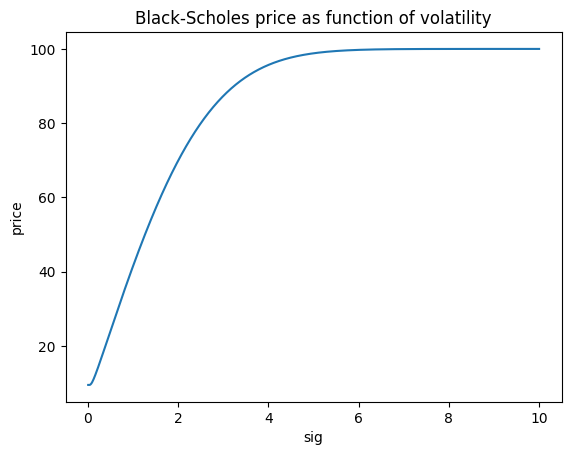

In [ ]:
BS_sigma = partial(BS_pricer.BlackScholes, "call", S0, K, T, r)  # binding the function
sigmas = np.linspace(0.01, 10, 1000)

plt.plot(sigmas, BS_sigma(sigmas))
plt.xlabel("sig")
plt.ylabel("price")
plt.title("Black-Scholes price as function of volatility")
plt.show()

The BS formula is an increasing function of the volatility.
However, for higher volatilities, the graph becomes almost flat!!

We can conclude that the model is reliable for volatilities in the range $0 - 400\%$.